In [1]:
# pip install --no-index --find-links=/kaggle/input/cmbrdata scikit-survival

Looking in links: /kaggle/input/cmbrdata
Processing /kaggle/input/cmbrdata/scikit_survival-0.23.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/cmbrdata/scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from scikit-survival)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.preprocessing import LabelEncoder

def handle_columns(df):
    """
    Handles both categorical and numerical columns in a DataFrame.
    
    - Categorical columns:
        - Replaces NaN with a placeholder 'NaN' to distinguish missing values.
        - Applies label encoding specific to each column.
        - Ensures the dtype remains numeric after encoding.
    
    - Numerical columns:
        - Replaces NaN values with the column mean.
        - Downcasts float64 to float32 and int64 to int32 for memory efficiency.

    Parameters:
    - df (pd.DataFrame): Input DataFrame to process.

    Returns:
    - pd.DataFrame: Processed DataFrame with handled missing values and optimized data types.
    """
    df = df.copy() 

    # Handle Categorical Columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        # Replace NaN with 'Missing' for categorical columns
        df[col] = df[col].fillna('NaN')
        
        # Apply Label Encoding to each categorical column
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
        # Convert to numeric type explicitly
        df[col] = df[col].astype(int)
    
    # Handle Numerical Columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    
    for col in numerical_cols:
        # Replace NaN values with the column mean
        df[col] = df[col].fillna(df[col].mean())
        
        # Downcast to reduce memory usage
        if df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')  # Downcast to float32
        elif df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')  # Downcast to int32
    
    return df


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sksurv.util import Surv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Prepare the data (same as before)
train_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
train_data = handle_columns(train_data)

# Check the columns
if 'efs' not in train_data.columns or 'efs_time' not in train_data.columns:
    raise ValueError("The dataset must contain 'efs' (event) and 'efs_time' (time-to-event) columns.")

# Convert 'efs' to boolean for survival analysis
train_data['efs'] = train_data['efs'].astype(bool)

# Create survival data from DataFrame
survival_data = Surv.from_dataframe("efs", "efs_time", train_data)

# Features and target
X = train_data.drop(columns=['efs', 'efs_time'])
y = survival_data

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:

# Build the Deep Learning Model
model = Sequential()

# Add input layer
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.01)))

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Output layer for Cox Proportional Hazards (log hazard ratio)
model.add(Dense(1, activation='linear'))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model with the Cox Proportional Hazards loss
"""def cox_loss(y_true, y_pred):
    event = y_true[:, 0]
    time = y_true[:, 1]
    
    # Ensure there are no NaN or infinite values in y_pred
    y_pred = tf.clip_by_value(y_pred, 1e-5, 1e5)
    
    risk = tf.exp(y_pred)  # Compute risk score from log-hazard ratio
    log_likelihood = event * y_pred - tf.cumsum(risk, axis=1)
    
    return -tf.reduce_mean(log_likelihood)"""

import tensorflow as tf

def cox_loss(y_true, y_pred):
    """
    Cox proportional hazards loss for survival analysis.

    Args:
        y_true: A tensor of shape (batch_size, 2), where
                - y_true[:, 0] is the event indicator (1 if event occurred, 0 otherwise)
                - y_true[:, 1] is the observed time
        y_pred: A tensor of shape (batch_size, 1), representing the predicted log hazard ratio.
    
    Returns:
        A scalar representing the Cox loss.
    """
    # Split the input into event indicator and survival times
    event = y_true[:, 0]
    time = y_true[:, 1]
    
    # Sort by time in descending order
    indices = tf.argsort(time, direction='DESCENDING')
    y_pred_sorted = tf.gather(y_pred, indices)
    event_sorted = tf.gather(event, indices)
    
    # Compute the risk scores
    risk = tf.exp(y_pred_sorted)
    
    # Compute the log cumulative sum of the risk scores
    log_cumsum_risk = tf.math.log(tf.cumsum(risk))
    
    # Compute the log-likelihood
    log_likelihood = y_pred_sorted - log_cumsum_risk
    log_likelihood = log_likelihood * event_sorted  # Only for events
    
    # Compute the negative mean log-likelihood
    loss = -tf.reduce_mean(log_likelihood)
    return loss

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=cox_loss)




In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=cox_loss)

In [19]:
y_train_input = np.column_stack((y_train['efs'], y_train['efs_time']))
y_val_input = np.column_stack((y_val['efs'], y_val['efs_time']))


In [20]:
# Train the model again
from tensorflow.keras.callbacks import EarlyStopping
import time

early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Stop training after 10 epochs of no improvement
    restore_best_weights=True  # Restore the model weights from the best epoch
)


print("Training started...")
start = time.time()
history = model.fit(X_train_scaled, 
          y_train_input, 
          epochs=100, 
          batch_size=16, 
          validation_data=(X_val_scaled, y_val_input),
          callbacks=[early_stopping])
end = time.time()
print(f"Total time to Train was {end-start}")


Training started...
Epoch 1/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0122 - val_loss: 0.9958
Epoch 2/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0140 - val_loss: 0.9956
Epoch 3/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0080 - val_loss: 0.9948
Epoch 4/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0219 - val_loss: 0.9939
Epoch 5/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0075 - val_loss: 0.9959
Epoch 6/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0219 - val_loss: 0.9971
Epoch 7/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0249 - val_loss: 0.9939
Epoch 8/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0003 - val_loss: 0.9944
Epoch 9/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0093 - val_loss: 0.9946
Epoch 10/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0093 - val_loss: 0.9952
Epoch 11/100
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0080 - val_loss: 0.9961

NameError: name 'end' is not defined

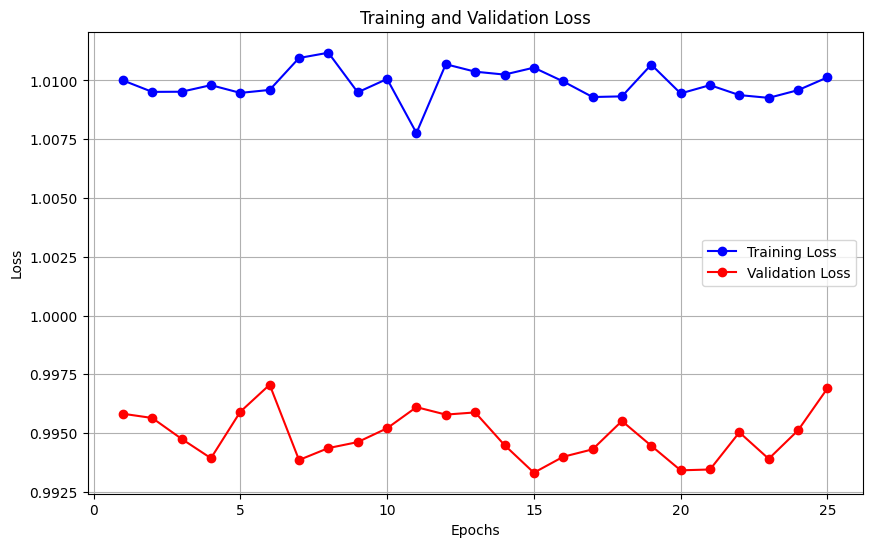

In [21]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

# Extract loss values for training and validation
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a plot
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sksurv.metrics import concordance_index_censored

# Predict the log-hazard ratios (output of the model)
y_pred = model.predict(X_val_scaled)

# Compute the C-index on the validation set
c_index = concordance_index_censored(y_val['efs'], y_val['efs_time'], y_pred.flatten())
print(f"C-index: {c_index[0]}")


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
C-index: 0.5912869637721772


In [27]:
test_df = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
test_data = handle_columns(test_df)

In [28]:
test_data_scaled = scaler.fit_transform(test_data)

In [ ]:
# Ensure predictions are 1-dimensional
test_data_ = test_data
test_risk_scores = model.predict(test_data_)
test_risk_scores = test_risk_scores.flatten()

# Prepare submission file
if "ID" in test_data.columns:
    submission = pd.DataFrame({
        "ID": test_data["ID"],
        "prediction": test_risk_scores
    })
else:
    raise ValueError("The test dataset must contain an 'ID' column.")

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")


In [32]:
"""test_data_ = test_data
test_risk_scores = model.predict(test_data_)

# Prepare submission file (without 'ID' column)
submission = pd.DataFrame({
    "ID": test_data["ID"],
    "prediction": test_risk_scores   
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")"""

Submission file created: submission.csv


In [33]:
submission

,ID,prediction
0,28800,911.215332
1,28801,910.036804
2,28802,912.614319
